# Word Embedding学习笔记4 - 应用

Word Embedding反映了单词间的关联程度，经常在一起出现的词倾向在词向量空间里互相接近，所以向量间距离与词间的关联高度相关。

## 1. 单词类比
下面来看一个通过Word Embedding寻找相似词的例子。训练word embedding的计算量非常大，一般的机器学习都是使用事先训练好的模型，这里也使用[GloVe](https://nlp.stanford.edu/projects/glove/)50维的模型。模型可以在网站上下载，模型就是一个文本文件，每一行的开头是单词，接下来按有顺序列出向量值。

### 加载模型

In [1]:
import numpy as np

In [5]:
word_to_vec_map = dict()
f = open('glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_to_vec_map[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [6]:
word_to_vec_map['cucumber']

array([ 0.68224 , -0.31608 , -0.95201 ,  0.47108 ,  0.56571 ,  0.13151 ,
        0.22457 ,  0.094995, -1.3237  , -0.51545 , -0.39337 ,  0.88488 ,
        0.93826 ,  0.22931 ,  0.088624, -0.53908 ,  0.23396 ,  0.73245 ,
       -0.019123, -0.26552 , -0.40433 , -1.5832  ,  1.1316  ,  0.4419  ,
       -0.48218 ,  0.4828  ,  0.14938 ,  1.1245  ,  1.0159  , -0.50213 ,
        0.83831 , -0.31303 ,  0.083242,  1.7161  ,  0.15024 ,  1.0324  ,
       -1.5005  ,  0.62348 ,  0.54508 , -0.88484 ,  0.53279 , -0.085119,
        0.02141 , -0.56629 ,  1.1463  ,  0.6464  ,  0.78318 , -0.067662,
        0.22884 , -0.042453], dtype=float32)

### Cosine Similarity

计算公式如下

$$\text{CosineSimilarity(u, v)} = \frac {u . v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

In [14]:
def cosine_similarity(u, v):

    dot = np.dot(u,v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    cosine_similarity = dot / (norm_u * norm_v) 
    return cosine_similarity

### 计算最佳单词匹配
找到一个单词，使用其与word_c最接近于word_a与word_b

In [15]:
def complete_analogy(word_a, word_b, word_c, word_to_vec_map):
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    e_a, e_b, e_c =  word_to_vec_map[word_a],  word_to_vec_map[word_b],  word_to_vec_map[word_c]
    
    words = word_to_vec_map.keys()
    max_cosine_sim = -100             
    best_word = None                   

    for w in words:        
        # to avoid best_word being one of the input words, pass on them.
        if w in [word_a, word_b, word_c] :
            continue

        cosine_sim =  cosine_similarity(e_b - e_a, word_to_vec_map[w] - e_c)
        
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
        
    return best_word

### 示例

给出italy, italian和china,它能找到Chinese，同样的heater和summer对应于cooler和winter。Word Embedding把自然语言映射到向量空间，保留了单词间的相关性，这使得Word Embedding能大幅提升机器学习的性能。我们也注意到word embedding并非一把万能钥匙，比如tree和tall，grass和6-feet就不是最好的匹配，所以在模型中还要辅之以其它手段。

In [19]:
triads_to_try = [('italy', 'italian', 'china'), ('india', 'delhi', 'japan'), 
                 ('man', 'woman', 'boy'), ('small', 'smaller', 'large'),
                ('heater', 'summer', 'cooler'),
                ('tree', 'tall', 'grass')]
for triad in triads_to_try:
    print ('{} -> {} :: {} -> {}'.format( *triad, complete_analogy(*triad,word_to_vec_map)))

italy -> italian :: china -> chinese
india -> delhi :: japan -> tokyo
man -> woman :: boy -> girl
small -> smaller :: large -> larger
heater -> summer :: cooler -> winter
tree -> tall :: grass -> 6-feet


## 2. 文本分类

Word Embedding还可以用于文本分类，一种常用的办法是把文本中所有的单词向量加和求平均，这样就可以得到一个文本向量，类似的利用这个向量我们可以给文本分类。我们来看下面这个例子

### Corpus

Corpus中都是一些简单的句子，根据含义打上标签

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
pd.options.display.max_colwidth = 200
%matplotlib inline

In [67]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!', 
          'We will have chicken salad and meatball on the lunch menu'
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals', 'food']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beautiful today,weather
7,The dog is lazy but the brown fox is quick!,animals
8,We will have chicken salad and meatball on the lunch menu,food


### 文本预处理

In [68]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

### 求向量平均

In [69]:
def average_word_vectors(words, word_to_vec_map, num_features):
    
    words = normalize_document(words).split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros((num_features,),dtype="float64")
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        avg += word_to_vec_map[w]
    avg = avg / len(words)
    
    return avg

In [71]:
def averaged_word_vectorizer(corpus,word_to_vec_map, num_features):
    features = [average_word_vectors(tokenized_sentence, word_to_vec_map, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [72]:
w2v_feature_array = averaged_word_vectorizer(corpus=corpus_df.Document, word_to_vec_map=word_to_vec_map,
                                             num_features=50)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.070063,0.948163,-0.435433,0.175210,0.608993,-0.240272,-0.888340,-0.617700,-0.141550,0.014403,...,0.095337,0.094762,0.042676,-0.412580,0.105943,-0.032980,0.032116,-1.113610,0.127025,-0.273236
1,-0.087262,0.996148,-0.539605,0.058378,0.645580,0.026701,-0.745780,-0.461470,-0.193068,0.279077,...,0.089193,0.022756,-0.014368,-0.349673,0.140128,0.027225,0.031818,-1.177982,0.023754,-0.132477
2,-0.155053,-0.181450,-0.129890,-0.173792,0.299837,0.366166,-0.671640,-0.184704,0.225717,-0.058557,...,-0.148406,0.405689,-0.484404,0.180538,0.259395,-0.476827,0.343665,-0.333145,0.443393,0.738926
3,0.130645,0.014894,-0.745699,-0.450485,0.603086,0.141869,-0.621366,0.115577,-0.468255,-0.074190,...,0.527570,0.309405,-0.364525,-0.066737,0.843510,0.984548,-0.337868,-0.060494,-0.193592,0.047151
4,0.172892,0.164394,-0.705757,-0.629519,0.631528,0.654967,-0.536804,-0.155917,-0.348110,0.000800,...,0.580172,0.112881,-0.165277,-0.193282,1.078478,0.766283,-0.234971,-0.359087,-0.065122,0.115561
5,-0.217797,-0.008480,-0.334692,-0.084680,0.350425,0.257451,-0.934252,-0.337239,0.078827,-0.187962,...,-0.049663,0.391125,-0.510334,0.087538,0.402928,-0.302605,0.087711,-0.479698,0.358139,0.699450
6,-0.025764,0.843176,-0.210532,0.244576,0.550792,-0.474389,-0.855704,-0.531754,-0.191738,-0.090750,...,0.078822,0.072205,0.043103,-0.309666,-0.014684,0.131104,-0.050228,-0.693502,0.078739,-0.242696
7,-0.093854,-0.149302,-0.298814,-0.148994,0.302126,0.314439,-0.879582,-0.207095,0.149908,-0.133194,...,-0.035248,0.481983,-0.597990,0.166470,0.359792,-0.301392,0.102778,-0.336318,0.421462,0.887272
8,0.284182,-0.362885,-1.216550,-0.027102,0.984914,-0.114748,-0.319011,-0.253618,0.149884,-0.231138,...,0.222712,0.567541,-0.391458,0.200307,0.784230,1.124014,0.215358,0.026194,0.482786,0.561606


### AP(Affinity Propagation)聚类算法

AP算法的基本思想是将全部样本看做网络的节点，然后通过网络中各条边的消息传递计算出个样本的聚类中心。聚类过程中，共有两种消息在各节点间传递，分别是吸引度（responsibility）和归属度（availability）。AP算法通过迭代过程不断更新每一个点的吸引度和归属度，直到产生m个高质量的Exemplar（相当于质心），同时将其余的数据点分配到相应的聚类

In [73]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,0
1,Love this blue and beautiful sky!,weather,0
2,The quick brown fox jumps over the lazy dog.,animals,2
3,"A king's breakfast has sausages, ham, bacon, eggs, toast and beans",food,1
4,"I love green eggs, ham, sausages and bacon!",food,1
5,The brown fox is quick and the blue dog is lazy!,animals,2
6,The sky is very blue and the sky is very beautiful today,weather,0
7,The dog is lazy but the brown fox is quick!,animals,2
8,We will have chicken salad and meatball on the lunch menu,food,1


### 两维PCA

Principal Component Analysis(PCA)是最常用的线性降维方法，它的目标是通过某种线性投影，将高维的数据映射到低维的空间中表示，并期望在所投影的维度上数据的方差最大，以此使用较少的数据维度，同时保留住较多的原数据点的特性。

我们把这些数据映射到两维空间方便绘图

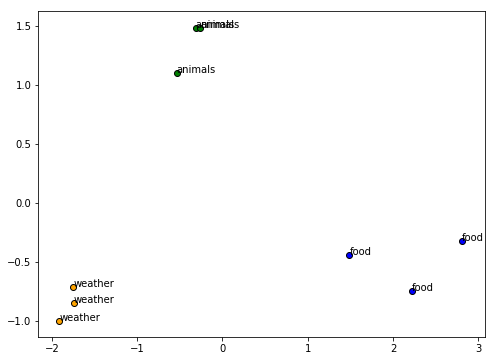

In [74]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')